In [6]:
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Input, Concatenate
from tensorflow.keras.optimizers import Adam
import plotly.graph_objects as go
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report
from tensorflow import random
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import json
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input


In [7]:
seed = 42
random.set_seed(seed)
np.random.seed(seed)


In [8]:
styles_path = '../styles.csv'

df = pd.read_csv(styles_path, on_bad_lines='skip')

df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [9]:
category_counts = df['articleType'].value_counts()

pd.set_option('display.max_rows', None) 
print(category_counts)

articleType
Tshirts                      7067
Shirts                       3217
Casual Shoes                 2845
Watches                      2542
Sports Shoes                 2036
Kurtas                       1844
Tops                         1762
Handbags                     1759
Heels                        1323
Sunglasses                   1073
Wallets                       936
Flip Flops                    914
Sandals                       897
Briefs                        849
Belts                         813
Backpacks                     724
Socks                         686
Formal Shoes                  637
Perfume and Body Mist         613
Jeans                         609
Shorts                        547
Trousers                      530
Flats                         500
Bra                           477
Dresses                       464
Sarees                        427
Earrings                      416
Deodorant                     347
Nail Polish                   329
Li

In [10]:
# WARIANTY KLAS GENDER
variant = 1  # Zmień na 1, 2, 3 lub 4

if variant == 1:
    # Wariant 1: tylko Woman i Man
    df = df[df['gender'].isin(['Men', 'Women'])]

elif variant == 2:
    # Wariant 2: Woman, Man, Kids (boys, girls), Unisex
    def map_gender(g):
        if g in ['Boys', 'Girls']:
            return 'Kids'
        return g
    df['gender'] = df['gender'].apply(map_gender)
    df = df[df['gender'].isin(['Men', 'Women', 'Kids', 'Unisex'])]

elif variant == 3:
    # Wariant 3: Woman, Man, Other (boys, girls, unisex)
    def map_gender(g):
        if g in ['Boys', 'Girls', 'Unisex']:
            return 'Other'
        return g
    df['gender'] = df['gender'].apply(map_gender)
    df = df[df['gender'].isin(['Men', 'Women', 'Other'])]

elif variant == 4:
    # Wariant 4: Woman, Man, Unisex
    df = df[df['gender'].isin(['Men', 'Women', 'Unisex'])]

# Sprawdź nowe klasy
gender_counts = df['gender'].value_counts()

pd.set_option('display.max_rows', None) 
print("Zmapowane klasy gender:")
print(gender_counts)

Zmapowane klasy gender:
gender
Men      22147
Women    18631
Name: count, dtype: int64


In [11]:
# ucinamy zbiór na 416 (zaleca sie 500)

In [12]:
df.isnull().sum()


id                      0
gender                  0
masterCategory          0
subCategory             0
articleType             0
baseColour             15
season                 15
year                    1
usage                 288
productDisplayName      7
dtype: int64

In [13]:
df.isnull().sum()
df.dropna(inplace=True)

In [14]:
df.isnull().sum()


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
dtype: int64

In [15]:
images_path = '../images/'

df['image_path'] = df['id'].apply(lambda x: os.path.join(images_path, f"{x}.jpg"))
df = df[df['image_path'].apply(os.path.exists)].copy() 

In [16]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,../images/15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,../images/39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,../images/59263.jpg
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants,../images/21379.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,../images/53759.jpg


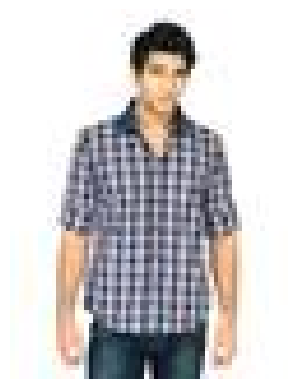

In [17]:
first_image_path = df['image_path'].iloc[0]

image = Image.open(first_image_path)
plt.imshow(image)
plt.axis('off')
plt.show()

In [18]:
category_counts = df['articleType'].value_counts()

min_count = 400

# filtered_categories = category_counts[category_counts >= min_count].index
filtered_categories = category_counts[category_counts > min_count].index

df = df[df['articleType'].isin(filtered_categories)]

category_counts = df['articleType'].value_counts()

for category, count in category_counts.items():
    print(f"{category}: {count}")

Tshirts: 6357
Shirts: 3133
Casual Shoes: 2580
Watches: 2375
Sports Shoes: 1976
Kurtas: 1839
Handbags: 1694
Tops: 1533
Heels: 1323
Sunglasses: 920
Wallets: 907
Briefs: 847
Belts: 804
Sandals: 751
Flip Flops: 743
Formal Shoes: 637
Socks: 614
Perfume and Body Mist: 595
Jeans: 553
Trousers: 523
Flats: 500
Bra: 477
Shorts: 456
Sarees: 427
Earrings: 415


In [19]:
df.isnull().sum()
df.dropna(inplace=True)
df.isnull().sum()


id                    0
gender                0
masterCategory        0
subCategory           0
articleType           0
baseColour            0
season                0
year                  0
usage                 0
productDisplayName    0
image_path            0
dtype: int64

In [20]:
df.to_csv('../backend/dataframe.csv', index=False)

In [21]:
df.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt,../images/15970.jpg
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans,../images/39386.jpg
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch,../images/59263.jpg
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt,../images/53759.jpg
5,1855,Men,Apparel,Topwear,Tshirts,Grey,Summer,2011.0,Casual,Inkfruit Mens Chain Reaction T-shirt,../images/1855.jpg


In [22]:
# preprocessing obrazków:

# def preprocess_image(image_path, target_size=(128, 128)):
#     img = load_img(image_path, target_size=target_size)
#     img_array = img_to_array(img) / 255.0  # Normalizacja
#     return img_array


In [23]:
def preprocess_image(image_path, target_size=(128, 128)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    return preprocess_input(img_array)

image_arrays = []
valid_indices = []

for idx, path in enumerate(df["image_path"]):
    img_array = preprocess_image(path)
    if img_array is not None:
        image_arrays.append(img_array)
        valid_indices.append(idx)

# Przefiltruj DataFrame by odpowiadał poprawnym obrazom
df_clean = df.iloc[valid_indices].reset_index(drop=True)
images = np.array(image_arrays)

In [24]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [25]:
gender_encoder = LabelEncoder()
article_encoder = LabelEncoder()

df_clean["gender_encoded"] = gender_encoder.fit_transform(df_clean["gender"])
df_clean["article_encoded"] = article_encoder.fit_transform(df_clean["articleType"])

y_gender = df_clean["gender_encoded"].values
y_article = df_clean["article_encoded"].values

In [26]:
X_train, X_val, y_gender_train, y_gender_val, y_article_train, y_article_val = train_test_split(images, y_gender, y_article, test_size=0.2, random_state=42)

In [27]:
input_tensor = Input(shape=(128, 128, 3))

# MobileNetV2 z wagami ImageNet, bez górnych warstw
base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')
base_model.trainable = False  # zamrożenie wag

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.5)(x)

# Wyjście 1: gender (multi-class)
gender_output = Dense(len(gender_encoder.classes_), activation="softmax", name="gender")(x)

# Wyjście 2: articleType (multi-class)
article_output = Dense(len(article_encoder.classes_), activation="softmax", name="article")(x)

# Model
model = Model(inputs=input_tensor, outputs=[gender_output, article_output])

/var/folders/7g/d8ckv1rx1kb58dsmtxs162780000gn/T/ipykernel_28468/1534803227.py:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(include_top=False, input_tensor=input_tensor, weights='imagenet')


In [28]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss={
        "gender": "sparse_categorical_crossentropy",
        "article": "sparse_categorical_crossentropy"
    },
    metrics={
        "gender": "accuracy",
        "article": "accuracy"
    }
)

In [29]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train,
    {"gender": y_gender_train, "article": y_article_train},
    validation_data=(X_val, {"gender": y_gender_val, "article": y_article_val}),
    epochs=10,
    batch_size=32
)

Epoch 1/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 66s 78ms/step - article_accuracy: 0.3385 - article_loss: 2.3668 - gender_accuracy: 0.7231 - gender_loss: 0.5508 - loss: 2.9176 - val_article_accuracy: 0.8134 - val_article_loss: 0.7059 - val_gender_accuracy: 0.8952 - val_gender_loss: 0.2538 - val_loss: 0.9600
Epoch 2/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 69s 83ms/step - article_accuracy: 0.7197 - article_loss: 0.9673 - gender_accuracy: 0.8551 - gender_loss: 0.3411 - loss: 1.3084 - val_article_accuracy: 0.8589 - val_article_loss: 0.4648 - val_gender_accuracy: 0.9154 - val_gender_loss: 0.2100 - val_loss: 0.6753
Epoch 3/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 74s 90ms/step - article_accuracy: 0.7859 - article_loss: 0.7082 - gender_accuracy: 0.8823 - gender_loss: 0.2751 - loss: 0.9834 - val_article_accuracy: 0.8727 - val_article_loss: 0.3904 - val_gender_accuracy: 0.9219 - val_gender_loss: 0.1923 - val_loss: 0.5826
Epoch 4/10
825/825 ━━━━━━━━━━━━━━━━━━━━ 80s 97ms/step - article_accuracy: 0.8172 - article_loss: 0.5

In [30]:
history.history

{'article_accuracy': [0.5048326849937439,
  0.7374066710472107,
  0.7915323972702026,
  0.8217412829399109,
  0.8362202644348145,
  0.8538832068443298,
  0.8630936741828918,
  0.8716219067573547,
  0.8807186484336853,
  0.8875791430473328],
 'article_loss': [1.739645004272461,
  0.887856662273407,
  0.680823028087616,
  0.5733696818351746,
  0.5075486302375793,
  0.4514031708240509,
  0.4130082130432129,
  0.3799855709075928,
  0.35164675116539,
  0.33244726061820984],
 'gender_accuracy': [0.7843686938285828,
  0.8622598052024841,
  0.8870105743408203,
  0.9016032814979553,
  0.9138081073760986,
  0.9209718108177185,
  0.9263541102409363,
  0.9319637417793274,
  0.937308132648468,
  0.9415532946586609],
 'gender_loss': [0.45171603560447693,
  0.3240624666213989,
  0.26720115542411804,
  0.23766937851905823,
  0.2122836410999298,
  0.19527556002140045,
  0.18261705338954926,
  0.16967886686325073,
  0.1568318009376526,
  0.14769527316093445],
 'loss': [2.1913251876831055,
  1.2116135358

In [31]:
print('last validation loss:', history.history['loss'][-1])
print('last validation loss:', history.history['val_loss'][-1])

last validation loss: 0.4800322353839874
last validation loss: 0.4611675441265106


In [32]:
# Całkowita strata
fig_loss_total = go.Figure()
fig_loss_total.add_trace(go.Scatter(y=history.history['loss'], mode='lines', name='Train Loss'))
fig_loss_total.add_trace(go.Scatter(y=history.history['val_loss'], mode='lines', name='Val Loss'))
fig_loss_total.update_layout(title='Total Loss', xaxis_title='Epoch', yaxis_title='Loss')
fig_loss_total.show()

# Strata per output
fig_loss_outputs = go.Figure()
fig_loss_outputs.add_trace(go.Scatter(y=history.history['gender_loss'], mode='lines', name='Train Gender Loss'))
fig_loss_outputs.add_trace(go.Scatter(y=history.history['val_gender_loss'], mode='lines', name='Val Gender Loss'))
fig_loss_outputs.add_trace(go.Scatter(y=history.history['article_loss'], mode='lines', name='Train Article Loss'))
fig_loss_outputs.add_trace(go.Scatter(y=history.history['val_article_loss'], mode='lines', name='Val Article Loss'))
fig_loss_outputs.update_layout(title='Loss per Output', xaxis_title='Epoch', yaxis_title='Loss')
fig_loss_outputs.show()

# ACC per output
fig_acc = go.Figure()

fig_acc.add_trace(go.Scatter(y=history.history['gender_accuracy'], mode='lines', name='Train Gender Accuracy'))
fig_acc.add_trace(go.Scatter(y=history.history['val_gender_accuracy'], mode='lines', name='Val Gender Accuracy'))

fig_acc.add_trace(go.Scatter(y=history.history['article_accuracy'], mode='lines', name='Train Article Accuracy'))
fig_acc.add_trace(go.Scatter(y=history.history['val_article_accuracy'], mode='lines', name='Val Article Accuracy'))

fig_acc.update_layout(title='Accuracy per Output', xaxis_title='Epoch', yaxis_title='Accuracy')
fig_acc.show()

In [33]:
results = model.evaluate(X_val, {"gender": y_gender_val, "article": y_article_val})
print("Wyniki walidacji:", results)

207/207 ━━━━━━━━━━━━━━━━━━━━ 17s 83ms/step - article_accuracy: 0.8966 - article_loss: 0.2945 - gender_accuracy: 0.9389 - gender_loss: 0.1646 - loss: 0.4591
Wyniki walidacji: [0.4611675441265106, 0.1652151495218277, 0.2979721128940582, 0.8941782712936401, 0.9396604299545288]


In [34]:
y_pred_gender, y_pred_article = model.predict(X_val)

y_pred_gender_classes = np.argmax(y_pred_gender, axis=1)
y_pred_article_classes = np.argmax(y_pred_article, axis=1)

print(classification_report(
    y_gender_val,
    y_pred_gender_classes,
    target_names=gender_encoder.classes_
))

print(classification_report(
    y_article_val,
    y_pred_article_classes,
    target_names=article_encoder.classes_
))

207/207 ━━━━━━━━━━━━━━━━━━━━ 18s 87ms/step
              precision    recall  f1-score   support

         Men       0.94      0.96      0.95      3875
       Women       0.95      0.91      0.93      2721

    accuracy                           0.94      6596
   macro avg       0.94      0.93      0.94      6596
weighted avg       0.94      0.94      0.94      6596

                       precision    recall  f1-score   support

                Belts       0.99      0.99      0.99       144
                  Bra       0.98      0.97      0.97       100
               Briefs       0.99      0.97      0.98       192
         Casual Shoes       0.77      0.77      0.77       516
             Earrings       0.99      0.99      0.99        87
                Flats       0.54      0.13      0.21        98
           Flip Flops       0.80      0.87      0.83       141
         Formal Shoes       0.80      0.74      0.77       124
             Handbags       0.97      0.97      0.97       363

In [35]:
# Mapowanie labeli do nazwa ArticleType
#labels = df['label'].values 
#label_mapping = dict(enumerate(df['articleType'].astype('category').cat.categories))
#print(label_mapping)

In [36]:
df['label'] = df['articleType'].astype('category').cat.codes
label_mapping = dict(enumerate(df['articleType'].astype('category').cat.categories))
print(label_mapping)

label_mapping_gender = dict(enumerate(df['gender'].astype('category').cat.categories))
print(label_mapping_gender)

{0: 'Belts', 1: 'Bra', 2: 'Briefs', 3: 'Casual Shoes', 4: 'Earrings', 5: 'Flats', 6: 'Flip Flops', 7: 'Formal Shoes', 8: 'Handbags', 9: 'Heels', 10: 'Jeans', 11: 'Kurtas', 12: 'Perfume and Body Mist', 13: 'Sandals', 14: 'Sarees', 15: 'Shirts', 16: 'Shorts', 17: 'Socks', 18: 'Sports Shoes', 19: 'Sunglasses', 20: 'Tops', 21: 'Trousers', 22: 'Tshirts', 23: 'Wallets', 24: 'Watches'}
{0: 'Men', 1: 'Women'}


In [37]:
image_path = os.path.join(images_path, '2208.jpg')

image_array = preprocess_image(image_path, target_size=(128, 128))
image_array = np.expand_dims(image_array, axis=0)  # (1, 128, 128, 3)

pred_gender, pred_article = model.predict(image_array)

pred_gender_class = np.argmax(pred_gender, axis=1)[0]
pred_article_class = np.argmax(pred_article, axis=1)[0]

pred_gender_label = gender_encoder.inverse_transform([pred_gender_class])[0]
pred_article_label = article_encoder.inverse_transform([pred_article_class])[0]

print(f"Predykcja dla obrazu {image_path}:")
print(f"Gender: {pred_gender_label} (klasa {pred_gender_class})")
print(f"Article Type: {pred_article_label} (klasa {pred_article_class})")
print(pred_gender)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Predykcja dla obrazu ../images/2208.jpg:
Gender: Men (klasa 0)
Article Type: Flip Flops (klasa 6)
[[0.92592865 0.07407137]]


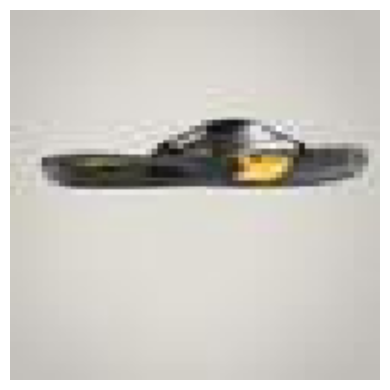

In [38]:
plt.figure(figsize=(4, 4))
img_display = load_img(image_path, target_size=(128, 128))
plt.imshow(img_display)
plt.axis('off')
plt.tight_layout()
plt.show()

In [39]:
print("y_article_val shape:", y_article_val.shape)
print("y_pred_article_classes shape:", y_pred_article_classes.shape)

print("Unikalne etykiety y_article_val:", np.unique(y_article_val))
print("Unikalne etykiety y_pred_article_classes:", np.unique(y_pred_article_classes))


y_article_val shape: (6596,)
y_pred_article_classes shape: (6596,)
Unikalne etykiety y_article_val: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]
Unikalne etykiety y_pred_article_classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24]


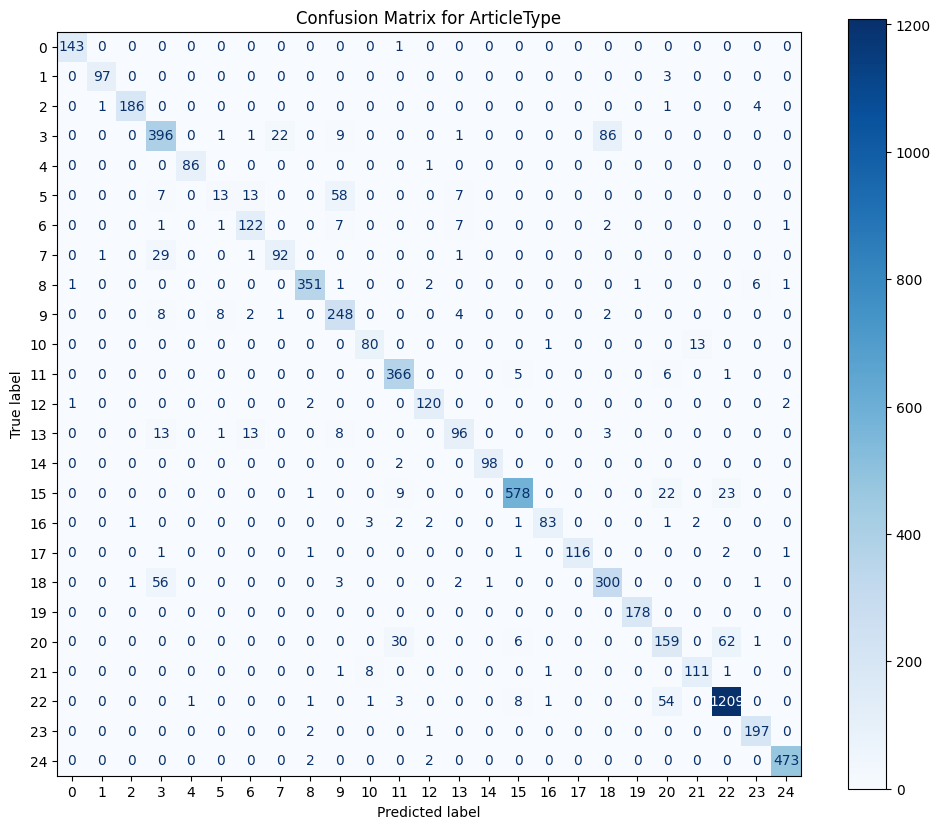

In [40]:
y_pred_article_classes = np.argmax(y_pred_article, axis=1)

cm = confusion_matrix(y_article_val, y_pred_article_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=article_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
disp.figure_.set_size_inches(12, 10)
plt.title('Confusion Matrix for ArticleType')
plt.show()

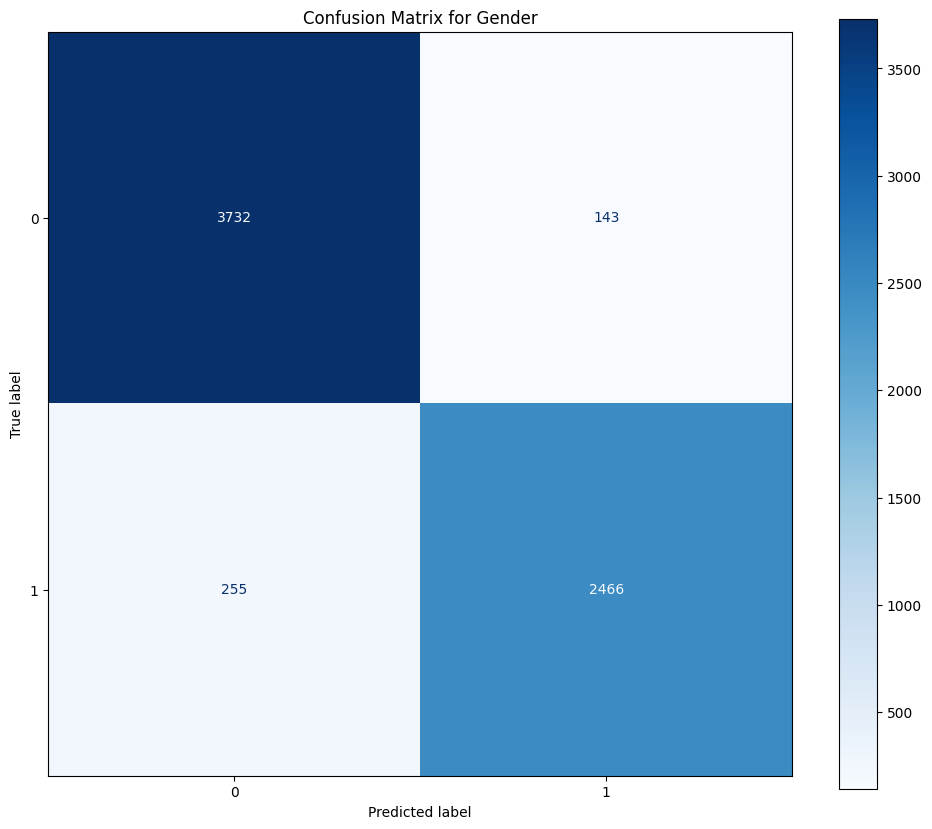

In [41]:
y_pred_gender_classes = np.argmax(y_pred_gender, axis=1)

cm = confusion_matrix(y_gender_val, y_pred_gender_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=article_encoder.classes_)
disp.plot(cmap=plt.cm.Blues)
disp.figure_.set_size_inches(12, 10)
plt.title('Confusion Matrix for Gender')
plt.show()

In [ ]:
#model.save('../backend/best_model.keras')